# Scripts del Proyecto

### Script 1: Preparación de datos para el entrenamiento

In [1]:
import pandas as pd

In [2]:
# Leemos la data de desarrollo de modelos
df = pd.read_csv('../data/raw/insurances.csv')

In [3]:
# Leemos la data de desarrollo de modelos
df = pd.read_csv('../data/raw/insurances.csv')

In [4]:
# Recodificamos variables 
df["Gender"] = df["Gender"].replace({"Male": 0, "Female": 1}).astype("int32")
df["Region_Code"] = df["Region_Code"].astype(int)
df["Vehicle_Age"] = df["Vehicle_Age"].replace({"< 1 Year": 0, "1-2 Year": 1, "> 2 Years": 2}).astype("int32")
df["Vehicle_Damage"] = df["Vehicle_Damage"].replace({"No": 0, "Yes": 1}).astype("int32")
df["Annual_Premium"] = df["Annual_Premium"].astype(int)
df["Policy_Sales_Channel"] = df["Policy_Sales_Channel"].astype(int)

In [5]:
# Transformamos variables
df["Previously_Insured_Annual_Premium"] = pd.factorize(
    df["Previously_Insured"].astype(str) + df["Annual_Premium"].astype(str)
)[0]

df["Previously_Insured_Vehicle_Age"] = pd.factorize(
    df["Previously_Insured"].astype(str) + df["Vehicle_Age"].astype(str)
)[0]

df["Previously_Insured_Vehicle_Damage"] = pd.factorize(
    df["Previously_Insured"].astype(str) + df["Vehicle_Damage"].astype(str)
)[0]

df["Previously_Insured_Vintage"] = pd.factorize(
    df["Previously_Insured"].astype(str) + df["Vintage"].astype(str)
)[0]

In [6]:
dfp = df[["Gender","Age","Previously_Insured","Vehicle_Age","Vehicle_Damage","Annual_Premium","Policy_Sales_Channel","Vintage","Previously_Insured_Annual_Premium","Previously_Insured_Vehicle_Damage","Previously_Insured_Vintage", "Response"]]
dfp.to_csv("../data/processed/insurances_train.csv", index = False)

### Script 2: Código de entrenamiento

In [1]:
import pandas as pd
import xgboost as xgb
import pickle
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_recall_curve
import numpy as np

In [2]:
# Cargar la tabla transformada
df = pd.read_csv("../data/processed/insurances_train.csv")
X_train = df.drop(['Response'],axis=1)
y_train = df[['Response']]

In [3]:
# Configuramos el subset de parametros a trabajar
cv_params = {'max_depth': [2,3,4],
            'subsample':[0.7,0.8,0.9],
             'n_estimators':[50,100,200]}

In [4]:
# Definimos un clasificador inicial, generalmente sin muchos parametros
xgboost_t=xgb.XGBClassifier().fit(X_train, y_train)

In [5]:
# Con el clasificador inicial, tratamos de buscar los mejores parametros
optimized_GBM = RandomizedSearchCV(xgboost_t, cv_params, scoring = 'accuracy', cv = 5) 

In [6]:
# Buscamos los parametros de acuerdo a nuestro criterio
opGBM=optimized_GBM.fit(X_train, y_train)

In [7]:
# De acuerdo a la busqueda , nos quedamos con los mejores parametros 
print(optimized_GBM.best_params_)

{'subsample': 0.8, 'n_estimators': 200, 'max_depth': 4}


In [8]:
# Guardamos el modelo entrenado para usarlo en produccion
filename = '../models/best_model.pkl'
pickle.dump(opGBM, open(filename, 'wb'))

### Script 3: Preparación de Datos de Validación


In [1]:
import pandas as pd

In [2]:
# Leemos la tabla de validación
df = pd.read_csv("../data/raw/insurances_new.csv")

In [3]:
# Recodificamos variables 
df["Gender"] = df["Gender"].replace({"Male": 0, "Female": 1}).astype("int32")
df["Region_Code"] = df["Region_Code"].astype(int)
df["Vehicle_Age"] = df["Vehicle_Age"].replace({"< 1 Year": 0, "1-2 Year": 1, "> 2 Years": 2}).astype("int32")
df["Vehicle_Damage"] = df["Vehicle_Damage"].replace({"No": 0, "Yes": 1}).astype("int32")
df["Annual_Premium"] = df["Annual_Premium"].astype(int)
df["Policy_Sales_Channel"] = df["Policy_Sales_Channel"].astype(int)

In [4]:
# Transformamos variables
df["Previously_Insured_Annual_Premium"] = pd.factorize(
    df["Previously_Insured"].astype(str) + df["Annual_Premium"].astype(str)
)[0]

df["Previously_Insured_Vehicle_Age"] = pd.factorize(
    df["Previously_Insured"].astype(str) + df["Vehicle_Age"].astype(str)
)[0]

df["Previously_Insured_Vehicle_Damage"] = pd.factorize(
    df["Previously_Insured"].astype(str) + df["Vehicle_Damage"].astype(str)
)[0]

df["Previously_Insured_Vintage"] = pd.factorize(
    df["Previously_Insured"].astype(str) + df["Vintage"].astype(str)
)[0]

In [5]:
dfp = df[["Gender","Age","Previously_Insured","Vehicle_Age","Vehicle_Damage","Annual_Premium","Policy_Sales_Channel","Vintage","Previously_Insured_Annual_Premium","Previously_Insured_Vehicle_Damage","Previously_Insured_Vintage", "Response"]]
dfp.to_csv("../data/processed/insurances_val.csv", index = False)

### Script 4: Código de Validación

In [1]:
import pandas as pd
import xgboost as xgb
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import *

In [2]:
# Cargar la tabla transformada
df = pd.read_csv("../data/processed/insurances_val.csv")
X_test = df.drop(['Response'],axis=1)
y_test = df[['Response']]

In [3]:
# Leemos el modelo entrenado!
filename = '../models/best_model.pkl'
model = pickle.load(open(filename, 'rb'))

In [5]:
y_prob_test = model.predict_proba(df.drop(['Response'], axis=1))[:, 1]
threshold = 0.248621
y_pred_test_threshold = (y_prob_test >= threshold).astype(int)

In [9]:
## Metricas de validación
def calc_metrics(y_test, y_pred_test):
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred_test)
    print("Matriz de confusión:")
    print(cm)
    # Classification report (precision, recall, f1, support)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_test))

In [10]:
calc_metrics(y_test, y_pred_test_threshold)

Matriz de confusión:
[[363528  74973]
 [ 19451  42047]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.83      0.89    438501
           1       0.36      0.68      0.47     61498

    accuracy                           0.81    499999
   macro avg       0.65      0.76      0.68    499999
weighted avg       0.88      0.81      0.83    499999



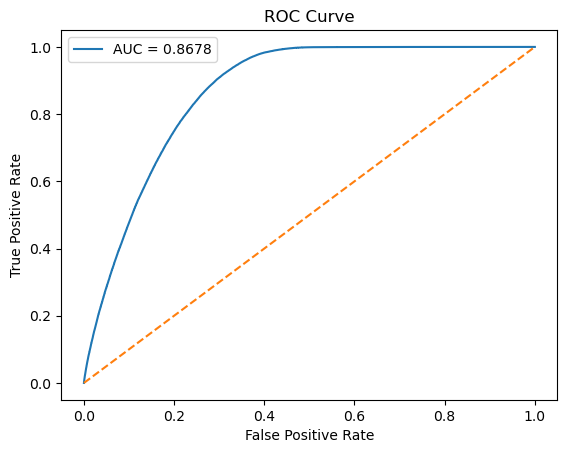

In [11]:
# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob_test)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

### Script 5: Preparación de Datos de Score (Automatización)

In [1]:
import pandas as pd

In [2]:
# Leemos la tabla de entrenamiento
df = pd.read_csv("../data/raw/insurances_score.csv")

In [3]:
# Recodificamos variables 
df["Gender"] = df["Gender"].replace({"Male": 0, "Female": 1}).astype("int32")
df["Region_Code"] = df["Region_Code"].astype(int)
df["Vehicle_Age"] = df["Vehicle_Age"].replace({"< 1 Year": 0, "1-2 Year": 1, "> 2 Years": 2}).astype("int32")
df["Vehicle_Damage"] = df["Vehicle_Damage"].replace({"No": 0, "Yes": 1}).astype("int32")
df["Annual_Premium"] = df["Annual_Premium"].astype(int)
df["Policy_Sales_Channel"] = df["Policy_Sales_Channel"].astype(int)

In [4]:
# Transformamos variables
df["Previously_Insured_Annual_Premium"] = pd.factorize(
    df["Previously_Insured"].astype(str) + df["Annual_Premium"].astype(str)
)[0]

df["Previously_Insured_Vehicle_Age"] = pd.factorize(
    df["Previously_Insured"].astype(str) + df["Vehicle_Age"].astype(str)
)[0]

df["Previously_Insured_Vehicle_Damage"] = pd.factorize(
    df["Previously_Insured"].astype(str) + df["Vehicle_Damage"].astype(str)
)[0]

df["Previously_Insured_Vintage"] = pd.factorize(
    df["Previously_Insured"].astype(str) + df["Vintage"].astype(str)
)[0]

In [5]:
dfp = df[["Gender","Age","Previously_Insured","Vehicle_Age","Vehicle_Damage","Annual_Premium","Policy_Sales_Channel","Vintage","Previously_Insured_Annual_Premium","Previously_Insured_Vehicle_Damage","Previously_Insured_Vintage"]]
dfp.to_csv("../data/processed/insurances_score.csv", index = False)

### Scipt 6: Código de Scoring (Automatización)

In [19]:
import pandas as pd
import pickle

In [20]:
# Cargar la tabla transformada
df = pd.read_csv("../data/processed/insurances_score.csv")

In [21]:
# Leemos el modelo entrenado!
filename = '../models/best_model.pkl'
model = pickle.load(open(filename, 'rb'))

In [22]:
y_prob_test = model.predict_proba(df)[:, 1]
threshold = 0.248621
scores = (y_prob_test >= threshold).astype(int)

In [23]:
# Exportamos el resultado del modelo para cargarlo en el Feature Store o Data Mart de Modelos
# Le asignamos nombres a las columnas
df_score = pd.DataFrame(scores, columns=['PREDICT'])
# Exportamos la solucion
df_score.to_csv('../data/scores/final_score.csv')